In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from utils.RAdam import RAdam
from PIL import Image
import cv2
import albumentations as A
import time
import os
from tqdm.notebook import tqdm
from utils.one_hot5 import mask2label1
from utils.pingjia import SegmentationMetric
# !pip install -q segmentation-models-pytorch
# !pip install -q torchsummary
from torchsummary import summary
import segmentation_models_pytorch as smp
from utils.pingjia import SegmentationMetric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMAGE_PATH = "D:\\lung\\train\\image1\\"
MASK_PATH ="D:\\lung\\train\\label1\\"

In [3]:
IMAGE_PATH1 = "D:\\lung\\test\\image1\\"
MASK_PATH1 = "D:\\lung\\test\\label1\\"

In [4]:
n_classes = 3


def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index=np.arange(0, len(name)))

def create_df1():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH1):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index=np.arange(0, len(name)))

df = create_df()
df1 = create_df1()
print('Total Images: ', len(df))

Total Images:  840


In [5]:
X_train = df['id'].values
X_val = df1['id'].values
print('Train Size   : ', len(X_train))
print('Test Size    : ', len(X_val))

Train Size   :  840
Test Size    :  160


In [6]:
# for i in range(1000):
#     print("num",i)
# #     img = Image.open(IMAGE_PATH + df['id'][i] + '.png')
# #     mask = Image.open(MASK_PATH + df['id'][i] + '.png')
#     img = cv2.imread(IMAGE_PATH + df['id'][i] + '.png')
#     mask = cv2.imread(MASK_PATH + df['id'][i] + '.png')
#     # print("mask",img.shape)
#     print('Image Size', np.asarray(img).shape)
#     print('Mask Size', np.asarray(mask).shape)
#     plt.imshow(img)

#     plt.imshow(mask1, alpha=0.5)
#     plt.title('Picture with Mask Appplied')
#     plt.show()

In [7]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        # print("image",img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        # print("mask",mask)
#         print("img",img.shape)
#         print("mask",mask.shape)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask


In [8]:
class DroneTestDataset1(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
#         mask = cv2.imread(self.mask_path + self.X[idx] + '.png')

        if self.transform is not None:
            
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [9]:
import albumentations as A

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([
                     A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
                     A.HorizontalFlip(p=0.25),
                     A.VerticalFlip(p=0.25),
                     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0, rotate_limit=5, p=0.2),
    
#                      A.GridDistortion(p=0.2),
#                      A.RandomBrightnessContrast((0,0.5),(0,0.5)),
#                      A.GaussNoise()
])
t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)

# t_val = A.Compose([
#                    A.Resize(288,288, interpolation=cv2.INTER_NEAREST),
#                    A.HorizontalFlip(),
# #                    A.GridDistortion(p=0.2)
# ])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH1, MASK_PATH1, X_val,mean, std, t_test, patch=False)
#dataloader

batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

In [10]:
model = smp.Unet('se_resnet50',
                 encoder_weights='imagenet',
                 classes=2, activation=None,
                 encoder_depth=5,
                 decoder_channels=[512,256, 128, 64, 32])
# model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True, num_classes=21, aux_loss=None)

# model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21, aux_loss=None)
# model.aux_classifier = nn.Sequential(nn.Conv2d(1024, 3,kernel_size=(1, 1), stride=(1, 1)))

# model = torchvision.models.segmentation.fcn_resnet50(pretrained=True, progress=True, num_classes=21, aux_loss=None)
# model.aux_classifier = nn.Sequential(nn.Linear(21,3))# 防止过拟合，提高泛化能力

# model = U_Net(3, 3)
# model = FCN(3, 3)

for param in model.parameters():
    param.requires_grad = True
print("model",model)

model Unet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inpl

In [11]:
max_lr = 1e-3
epoch =50
weight_decay = 1e-4
# criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss2()
# a = 0.5
criterion = nn.CrossEntropyLoss()
# criterion2 = FocalLoss2()

In [12]:
#优化器
# AdaW+OneCycleLR
optimizer = RAdam(model.parameters(), lr=0.001)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

# RAdam+OneCycleLR
# optimizer = RAdam(model.parameters(), lr=0.001)
# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
#                                             steps_per_epoch=len(train_loader))

# RAdam+ReduceLROnPlateau
# optimizer = RAdam(model.parameters(), lr=0.001)
# sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=300, cooldown=10)


# optimizer = RAdam(model.parameters(), lr=0.1,weight_decay=weight_decay)
# sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [13]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [14]:
def fit(epochs, model, train_loader, val_loader, criterion,optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    beset_miou = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    train_cpa = []
    val_cpa = []
    min_loss = np.inf
    min_miou = 0
    min_cpa = 0
    min_recall = 0
    best = 0
    decrease = 1
    not_improve = 0
    train_miou = []
    val_miou = []
    train_recall = []
    val_recall = []
    train_f1 = []
    val_f1 = []

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        cpa = 0
        miou1 = 0
        recall = 0
        f1 = 0
        # training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            image_tiles, mask_tiles = data


            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            # forward
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            output = model(image)

            loss = criterion(output,mask)
            metric = SegmentationMetric(2)  # ()里面表示分类
            metric.addBatch(output, mask_tiles)
# 评价指标中去除了背景
            cpa += metric.meanPixelAccuracy()
            miou1 += metric.meanIntersectionOverUnion()
            recall += metric.recall()
            f1 += metric.F1Score()
            accuracy += metric.pixelAccuracy()

            # backward
            loss.backward()
            optimizer.step()  # update weight
            optimizer.zero_grad()  # reset gradient

            # step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            val_cpa_score = 0
            test_miou = 0
            val_Recall = 0
            val_F1 = 0
            # validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)

                    output = model(image)

                    # loss



                    loss = criterion(output, mask)


                    test_loss += loss.item()

                    metric = SegmentationMetric(2)
                    metric.addBatch(output, mask_tiles)
                    val_cpa_score += metric.meanPixelAccuracy()
                    test_miou += metric.meanIntersectionOverUnion()
                    val_Recall += metric.recall()
                    val_F1 += metric.F1Score()
                    test_accuracy += metric.pixelAccuracy()

            # calculatio mean for each batch
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))


            if (test_miou / len(val_loader)) > min_miou:
                min_miou = (test_miou / len(val_loader))
                torch.save(model.state_dict(), "F:\\unet2\\weight\\lung\\" + "best_miou1.pth")
                torch.save(model, "F:\\unet2\\weight\\lung\\" + "best_miou1.pt")
                print("best miou has saved:{:.3f} --- > {:.3f}".format(min_miou, (test_miou / len(val_loader))))

            if val_cpa_score / len(val_loader) > min_cpa:
                min_cpa = val_cpa_score / len(val_loader)
                torch.save(model.state_dict(), "F:\\unet2\\weight\\lung\\" + "best_cpa1.pth")
                torch.save(model, "F:\\unet2\\weight\\lung\\" + "best_cpa1.pt")
                print("best cpa has saved:{:.3f} --- > {:.3f}".format(min_cpa, (val_cpa_score / len(val_loader))))

            if val_Recall / len(val_loader) > min_recall:
                min_recall = val_Recall / len(val_loader)
                torch.save(model.state_dict(), "F:\\unet2\\weight\\lung\\" + "best_recall1.pth")
                torch.save(model, "F:\\unet2\\weight\\lung\\" + "best_recall1.pt")
                print("best recall has saved:{:.3f} --- > {:.3f}".format(min_recall, (val_Recall / len(val_loader))))

            best1 = (val_Recall / len(val_loader)) * 0.65 + (test_miou / len(val_loader)) * 0.35

            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            train_cpa.append(cpa / len(train_loader))
            val_cpa.append(val_cpa_score / len(val_loader))
            train_miou.append(miou1 / len(train_loader))
            val_miou.append(test_miou / len(val_loader))
            train_recall.append(recall / len(train_loader))
            val_recall.append(val_Recall / len(val_loader))
            train_f1.append(f1 / len(train_loader))
            val_f1.append(val_F1 / len(val_loader))

            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Loss: {:.4f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.4f}..".format(test_loss / len(val_loader)),
#                   "Train mIoU:{:.4f}..".format(iou_score / len(train_loader)),
#                   "Val mIoU: {:.4f}..".format(val_iou_score / len(val_loader)),
                  "Train Acc:{:.4f}..".format(accuracy / len(train_loader)),
                  "Val Acc:{:.4f}..".format(test_accuracy / len(val_loader)),
                  "train_cpa:{:.4f}..".format(cpa / len(train_loader)),
                  "val_cpa:{:.4f}..".format(val_cpa_score / len(val_loader)),
                  "train_miou:{:.4f}..".format(miou1 / len(train_loader)),
                  "val_miou:{:.4f}..".format(test_miou / len(val_loader)),
                  "train_recall:{:.4f}..".format(recall / len(train_loader)),
                  "val_recall:{:.4f}..".format(val_Recall / len(val_loader)),
                  "train_f1:{:.4f}..".format(f1 / len(train_loader)),
                  "val_f1:{:.4f}..".format(val_F1 / len(val_loader)),
                  "Time: {:.4f}m".format((time.time() - since) / 60))
        if e % 50 == 0:
            print('saving model...')
            torch.save(model.state_dict(), "F:\\unet2\\weight\\lung\\" + "unet" + "%03d" % (e) + ".pth")
            torch.save(model, "F:\\unet2\\weight\\lung\\" + "UNet" + "%03d" % (e) + ".pt")

    history = {'train_loss': train_losses, 'val_loss': test_losses,
               'train_miou': train_iou, 'val_miou': val_iou,
               'train_acc': train_acc, 'val_acc': val_acc,
               'train_cpa': train_cpa, 'val_cpa': val_cpa,
               'train_miou1': train_miou, 'val_miou1': val_miou,
               'train_recall': train_recall, 'val_recall': val_recall,
               'train_f1': train_f1, 'val_f1': val_f1,
               'lrs': lrs}

    print('Total time: {:.3f} m'.format((time.time() - fit_time) / 60))
    return history




In [15]:
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

F:\unet\utils\RAdam.py:55: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1005.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)



best miou has saved:0.585 --- > 0.585
best cpa has saved:0.626 --- > 0.626
best recall has saved:0.907 --- > 0.907
Epoch:1/50.. Train Loss: 0.5648.. Val Loss: 0.3748.. Train Acc:0.7161.. Val Acc:0.8613.. train_cpa:0.4220.. val_cpa:0.6258.. train_miou:0.3710.. val_miou:0.5849.. train_recall:0.7094.. val_recall:0.9074.. train_f1:0.6619.. val_f1:0.8192.. Time: 0.7287m
saving model...



best miou has saved:0.862 --- > 0.862
best cpa has saved:0.924 --- > 0.924
best recall has saved:0.929 --- > 0.929
Epoch:2/50.. Train Loss: 0.2261.. Val Loss: 0.1417.. Train Acc:0.9408.. Val Acc:0.9680.. train_cpa:0.8362.. val_cpa:0.9245.. train_miou:0.7769.. val_miou:0.8617.. train_recall:0.9166.. val_recall:0.9292.. train_f1:0.9169.. val_f1:0.9518.. Time: 0.7094m



best miou has saved:0.899 --- > 0.899
best cpa has saved:0.961 --- > 0.961
best recall has saved:0.934 --- > 0.934
Epoch:3/50.. Train Loss: 0.1109.. Val Loss: 0.0832.. Train Acc:0.9723.. Val Acc:0.9773.. train_cpa:0.9373.. val_cpa:0.9611.. train_miou:0.8797.. val_miou:0.8994.. train_recall:0.9354.. val_recall:0.9341.. train_f1:0.9591.. val_f1:0.9657.. Time: 0.7029m



best miou has saved:0.915 --- > 0.915
best cpa has saved:0.962 --- > 0.962
best recall has saved:0.949 --- > 0.949
Epoch:4/50.. Train Loss: 0.0745.. Val Loss: 0.0618.. Train Acc:0.9786.. Val Acc:0.9808.. train_cpa:0.9523.. val_cpa:0.9620.. train_miou:0.9061.. val_miou:0.9147.. train_recall:0.9497.. val_recall:0.9495.. train_f1:0.9684.. val_f1:0.9710.. Time: 0.7151m



best miou has saved:0.915 --- > 0.915
best cpa has saved:0.979 --- > 0.979
Epoch:5/50.. Train Loss: 0.0534.. Val Loss: 0.0527.. Train Acc:0.9832.. Val Acc:0.9816.. train_cpa:0.9635.. val_cpa:0.9787.. train_miou:0.9252.. val_miou:0.9150.. train_recall:0.9591.. val_recall:0.9335.. train_f1:0.9752.. val_f1:0.9714.. Time: 0.6215m



best miou has saved:0.923 --- > 0.923
best recall has saved:0.957 --- > 0.957
Epoch:6/50.. Train Loss: 0.0439.. Val Loss: 0.0467.. Train Acc:0.9849.. Val Acc:0.9827.. train_cpa:0.9668.. val_cpa:0.9632.. train_miou:0.9323.. val_miou:0.9234.. train_recall:0.9634.. val_recall:0.9572.. train_f1:0.9776.. val_f1:0.9741.. Time: 0.6761m



best miou has saved:0.928 --- > 0.928
Epoch:7/50.. Train Loss: 0.0403.. Val Loss: 0.0410.. Train Acc:0.9851.. Val Acc:0.9841.. train_cpa:0.9679.. val_cpa:0.9781.. train_miou:0.9330.. val_miou:0.9276.. train_recall:0.9632.. val_recall:0.9473.. train_f1:0.9779.. val_f1:0.9758.. Time: 0.5940m



best miou has saved:0.934 --- > 0.934
best recall has saved:0.973 --- > 0.973
Epoch:8/50.. Train Loss: 0.0376.. Val Loss: 0.0371.. Train Acc:0.9858.. Val Acc:0.9852.. train_cpa:0.9688.. val_cpa:0.9597.. train_miou:0.9362.. val_miou:0.9343.. train_recall:0.9655.. val_recall:0.9725.. train_f1:0.9790.. val_f1:0.9780.. Time: 0.6208m



best recall has saved:0.975 --- > 0.975
Epoch:9/50.. Train Loss: 0.0362.. Val Loss: 0.0408.. Train Acc:0.9861.. Val Acc:0.9838.. train_cpa:0.9702.. val_cpa:0.9500.. train_miou:0.9378.. val_miou:0.9275.. train_recall:0.9658.. val_recall:0.9747.. train_f1:0.9795.. val_f1:0.9756.. Time: 0.5968m



Epoch:10/50.. Train Loss: 0.0371.. Val Loss: 0.0405.. Train Acc:0.9855.. Val Acc:0.9836.. train_cpa:0.9693.. val_cpa:0.9685.. train_miou:0.9352.. val_miou:0.9256.. train_recall:0.9640.. val_recall:0.9543.. train_f1:0.9786.. val_f1:0.9750.. Time: 0.5756m



best miou has saved:0.937 --- > 0.937
Epoch:11/50.. Train Loss: 0.0347.. Val Loss: 0.0359.. Train Acc:0.9862.. Val Acc:0.9861.. train_cpa:0.9705.. val_cpa:0.9638.. train_miou:0.9376.. val_miou:0.9368.. train_recall:0.9653.. val_recall:0.9707.. train_f1:0.9795.. val_f1:0.9789.. Time: 0.6021m



Epoch:12/50.. Train Loss: 0.0308.. Val Loss: 0.0371.. Train Acc:0.9876.. Val Acc:0.9854.. train_cpa:0.9726.. val_cpa:0.9723.. train_miou:0.9441.. val_miou:0.9358.. train_recall:0.9700.. val_recall:0.9613.. train_f1:0.9816.. val_f1:0.9783.. Time: 0.5726m



best miou has saved:0.937 --- > 0.937
Epoch:13/50.. Train Loss: 0.0323.. Val Loss: 0.0340.. Train Acc:0.9871.. Val Acc:0.9860.. train_cpa:0.9726.. val_cpa:0.9712.. train_miou:0.9420.. val_miou:0.9372.. train_recall:0.9678.. val_recall:0.9639.. train_f1:0.9809.. val_f1:0.9790.. Time: 0.5969m



Epoch:14/50.. Train Loss: 0.0334.. Val Loss: 0.0371.. Train Acc:0.9866.. Val Acc:0.9848.. train_cpa:0.9719.. val_cpa:0.9613.. train_miou:0.9401.. val_miou:0.9311.. train_recall:0.9665.. val_recall:0.9674.. train_f1:0.9803.. val_f1:0.9768.. Time: 0.5658m



best miou has saved:0.941 --- > 0.941
Epoch:15/50.. Train Loss: 0.0345.. Val Loss: 0.0319.. Train Acc:0.9862.. Val Acc:0.9869.. train_cpa:0.9710.. val_cpa:0.9654.. train_miou:0.9381.. val_miou:0.9410.. train_recall:0.9653.. val_recall:0.9737.. train_f1:0.9796.. val_f1:0.9804.. Time: 0.5770m



Epoch:16/50.. Train Loss: 0.0328.. Val Loss: 0.0339.. Train Acc:0.9868.. Val Acc:0.9860.. train_cpa:0.9712.. val_cpa:0.9750.. train_miou:0.9404.. val_miou:0.9377.. train_recall:0.9674.. val_recall:0.9606.. train_f1:0.9804.. val_f1:0.9791.. Time: 0.5665m



best miou has saved:0.944 --- > 0.944
Epoch:17/50.. Train Loss: 0.0281.. Val Loss: 0.0291.. Train Acc:0.9886.. Val Acc:0.9879.. train_cpa:0.9746.. val_cpa:0.9779.. train_miou:0.9484.. val_miou:0.9441.. train_recall:0.9726.. val_recall:0.9645.. train_f1:0.9831.. val_f1:0.9815.. Time: 0.6044m



Epoch:18/50.. Train Loss: 0.0272.. Val Loss: 0.0313.. Train Acc:0.9889.. Val Acc:0.9875.. train_cpa:0.9760.. val_cpa:0.9781.. train_miou:0.9501.. val_miou:0.9438.. train_recall:0.9730.. val_recall:0.9640.. train_f1:0.9837.. val_f1:0.9813.. Time: 0.5741m



best cpa has saved:0.980 --- > 0.980
Epoch:19/50.. Train Loss: 0.0271.. Val Loss: 0.0300.. Train Acc:0.9889.. Val Acc:0.9875.. train_cpa:0.9759.. val_cpa:0.9799.. train_miou:0.9499.. val_miou:0.9431.. train_recall:0.9728.. val_recall:0.9616.. train_f1:0.9836.. val_f1:0.9811.. Time: 0.5940m



Epoch:20/50.. Train Loss: 0.0290.. Val Loss: 0.0507.. Train Acc:0.9883.. Val Acc:0.9811.. train_cpa:0.9746.. val_cpa:0.9447.. train_miou:0.9473.. val_miou:0.9163.. train_recall:0.9713.. val_recall:0.9687.. train_f1:0.9827.. val_f1:0.9716.. Time: 0.5691m



best recall has saved:0.980 --- > 0.980
Epoch:21/50.. Train Loss: 0.0303.. Val Loss: 0.0290.. Train Acc:0.9876.. Val Acc:0.9878.. train_cpa:0.9728.. val_cpa:0.9627.. train_miou:0.9444.. val_miou:0.9438.. train_recall:0.9701.. val_recall:0.9796.. train_f1:0.9817.. val_f1:0.9814.. Time: 0.6077m



best miou has saved:0.947 --- > 0.947
Epoch:22/50.. Train Loss: 0.0263.. Val Loss: 0.0285.. Train Acc:0.9891.. Val Acc:0.9883.. train_cpa:0.9756.. val_cpa:0.9733.. train_miou:0.9508.. val_miou:0.9472.. train_recall:0.9740.. val_recall:0.9727.. train_f1:0.9839.. val_f1:0.9825.. Time: 0.5939m



best miou has saved:0.950 --- > 0.950
Epoch:23/50.. Train Loss: 0.0241.. Val Loss: 0.0275.. Train Acc:0.9900.. Val Acc:0.9889.. train_cpa:0.9777.. val_cpa:0.9727.. train_miou:0.9545.. val_miou:0.9500.. train_recall:0.9759.. val_recall:0.9759.. train_f1:0.9852.. val_f1:0.9834.. Time: 0.5941m



best cpa has saved:0.980 --- > 0.980
Epoch:24/50.. Train Loss: 0.0231.. Val Loss: 0.0320.. Train Acc:0.9904.. Val Acc:0.9868.. train_cpa:0.9786.. val_cpa:0.9804.. train_miou:0.9565.. val_miou:0.9405.. train_recall:0.9770.. val_recall:0.9584.. train_f1:0.9858.. val_f1:0.9802.. Time: 0.5973m



Epoch:25/50.. Train Loss: 0.0243.. Val Loss: 0.0290.. Train Acc:0.9900.. Val Acc:0.9883.. train_cpa:0.9777.. val_cpa:0.9784.. train_miou:0.9547.. val_miou:0.9468.. train_recall:0.9760.. val_recall:0.9670.. train_f1:0.9852.. val_f1:0.9824.. Time: 0.5774m



Epoch:26/50.. Train Loss: 0.0221.. Val Loss: 0.0299.. Train Acc:0.9909.. Val Acc:0.9879.. train_cpa:0.9797.. val_cpa:0.9645.. train_miou:0.9584.. val_miou:0.9449.. train_recall:0.9779.. val_recall:0.9790.. train_f1:0.9865.. val_f1:0.9817.. Time: 0.5417m



best cpa has saved:0.982 --- > 0.982
Epoch:27/50.. Train Loss: 0.0208.. Val Loss: 0.0288.. Train Acc:0.9913.. Val Acc:0.9888.. train_cpa:0.9808.. val_cpa:0.9821.. train_miou:0.9606.. val_miou:0.9491.. train_recall:0.9791.. val_recall:0.9657.. train_f1:0.9872.. val_f1:0.9831.. Time: 0.5674m



best miou has saved:0.950 --- > 0.950
Epoch:28/50.. Train Loss: 0.0199.. Val Loss: 0.0279.. Train Acc:0.9917.. Val Acc:0.9891.. train_cpa:0.9818.. val_cpa:0.9756.. train_miou:0.9622.. val_miou:0.9503.. train_recall:0.9797.. val_recall:0.9734.. train_f1:0.9877.. val_f1:0.9835.. Time: 0.5562m



best cpa has saved:0.983 --- > 0.983
Epoch:29/50.. Train Loss: 0.0213.. Val Loss: 0.0287.. Train Acc:0.9912.. Val Acc:0.9885.. train_cpa:0.9807.. val_cpa:0.9830.. train_miou:0.9601.. val_miou:0.9477.. train_recall:0.9786.. val_recall:0.9633.. train_f1:0.9870.. val_f1:0.9827.. Time: 0.5608m



best miou has saved:0.951 --- > 0.951
Epoch:30/50.. Train Loss: 0.0204.. Val Loss: 0.0268.. Train Acc:0.9915.. Val Acc:0.9893.. train_cpa:0.9812.. val_cpa:0.9827.. train_miou:0.9615.. val_miou:0.9513.. train_recall:0.9796.. val_recall:0.9675.. train_f1:0.9875.. val_f1:0.9839.. Time: 0.5593m



best miou has saved:0.953 --- > 0.953
Epoch:31/50.. Train Loss: 0.0200.. Val Loss: 0.0262.. Train Acc:0.9917.. Val Acc:0.9896.. train_cpa:0.9821.. val_cpa:0.9747.. train_miou:0.9624.. val_miou:0.9528.. train_recall:0.9797.. val_recall:0.9770.. train_f1:0.9877.. val_f1:0.9844.. Time: 0.5612m



best miou has saved:0.955 --- > 0.955
Epoch:32/50.. Train Loss: 0.0181.. Val Loss: 0.0253.. Train Acc:0.9924.. Val Acc:0.9901.. train_cpa:0.9833.. val_cpa:0.9795.. train_miou:0.9654.. val_miou:0.9550.. train_recall:0.9815.. val_recall:0.9745.. train_f1:0.9888.. val_f1:0.9851.. Time: 0.5603m



Epoch:33/50.. Train Loss: 0.0179.. Val Loss: 0.0284.. Train Acc:0.9924.. Val Acc:0.9891.. train_cpa:0.9832.. val_cpa:0.9813.. train_miou:0.9658.. val_miou:0.9511.. train_recall:0.9820.. val_recall:0.9686.. train_f1:0.9889.. val_f1:0.9838.. Time: 0.5416m



best recall has saved:0.980 --- > 0.980
Epoch:34/50.. Train Loss: 0.0178.. Val Loss: 0.0264.. Train Acc:0.9926.. Val Acc:0.9894.. train_cpa:0.9837.. val_cpa:0.9711.. train_miou:0.9663.. val_miou:0.9521.. train_recall:0.9821.. val_recall:0.9799.. train_f1:0.9890.. val_f1:0.9841.. Time: 0.5712m



Epoch:35/50.. Train Loss: 0.0166.. Val Loss: 0.0257.. Train Acc:0.9929.. Val Acc:0.9896.. train_cpa:0.9843.. val_cpa:0.9796.. train_miou:0.9679.. val_miou:0.9527.. train_recall:0.9831.. val_recall:0.9718.. train_f1:0.9896.. val_f1:0.9843.. Time: 0.5440m



Epoch:36/50.. Train Loss: 0.0163.. Val Loss: 0.0254.. Train Acc:0.9931.. Val Acc:0.9899.. train_cpa:0.9845.. val_cpa:0.9806.. train_miou:0.9686.. val_miou:0.9542.. train_recall:0.9836.. val_recall:0.9725.. train_f1:0.9898.. val_f1:0.9849.. Time: 0.5403m



best miou has saved:0.955 --- > 0.955
best recall has saved:0.981 --- > 0.981
Epoch:37/50.. Train Loss: 0.0158.. Val Loss: 0.0253.. Train Acc:0.9934.. Val Acc:0.9902.. train_cpa:0.9853.. val_cpa:0.9730.. train_miou:0.9697.. val_miou:0.9554.. train_recall:0.9841.. val_recall:0.9813.. train_f1:0.9902.. val_f1:0.9853.. Time: 0.6188m



best miou has saved:0.956 --- > 0.956
Epoch:38/50.. Train Loss: 0.0147.. Val Loss: 0.0259.. Train Acc:0.9938.. Val Acc:0.9904.. train_cpa:0.9861.. val_cpa:0.9760.. train_miou:0.9715.. val_miou:0.9562.. train_recall:0.9850.. val_recall:0.9792.. train_f1:0.9908.. val_f1:0.9856.. Time: 0.5670m



best miou has saved:0.956 --- > 0.956
Epoch:39/50.. Train Loss: 0.0142.. Val Loss: 0.0265.. Train Acc:0.9940.. Val Acc:0.9904.. train_cpa:0.9867.. val_cpa:0.9789.. train_miou:0.9726.. val_miou:0.9563.. train_recall:0.9856.. val_recall:0.9764.. train_f1:0.9911.. val_f1:0.9855.. Time: 0.5616m



best miou has saved:0.957 --- > 0.957
Epoch:40/50.. Train Loss: 0.0140.. Val Loss: 0.0256.. Train Acc:0.9941.. Val Acc:0.9907.. train_cpa:0.9869.. val_cpa:0.9789.. train_miou:0.9731.. val_miou:0.9575.. train_recall:0.9859.. val_recall:0.9776.. train_f1:0.9913.. val_f1:0.9860.. Time: 0.5629m



Epoch:41/50.. Train Loss: 0.0137.. Val Loss: 0.0256.. Train Acc:0.9942.. Val Acc:0.9907.. train_cpa:0.9869.. val_cpa:0.9801.. train_miou:0.9736.. val_miou:0.9573.. train_recall:0.9864.. val_recall:0.9763.. train_f1:0.9915.. val_f1:0.9860.. Time: 0.5403m



Epoch:42/50.. Train Loss: 0.0129.. Val Loss: 0.0261.. Train Acc:0.9945.. Val Acc:0.9907.. train_cpa:0.9877.. val_cpa:0.9808.. train_miou:0.9750.. val_miou:0.9574.. train_recall:0.9871.. val_recall:0.9757.. train_f1:0.9919.. val_f1:0.9860.. Time: 0.5419m



best miou has saved:0.958 --- > 0.958
Epoch:43/50.. Train Loss: 0.0127.. Val Loss: 0.0255.. Train Acc:0.9946.. Val Acc:0.9909.. train_cpa:0.9880.. val_cpa:0.9813.. train_miou:0.9754.. val_miou:0.9582.. train_recall:0.9871.. val_recall:0.9761.. train_f1:0.9920.. val_f1:0.9862.. Time: 0.5610m



best cpa has saved:0.984 --- > 0.984
Epoch:44/50.. Train Loss: 0.0126.. Val Loss: 0.0266.. Train Acc:0.9947.. Val Acc:0.9908.. train_cpa:0.9881.. val_cpa:0.9835.. train_miou:0.9758.. val_miou:0.9579.. train_recall:0.9874.. val_recall:0.9736.. train_f1:0.9922.. val_f1:0.9861.. Time: 0.5624m



best miou has saved:0.959 --- > 0.959
Epoch:45/50.. Train Loss: 0.0121.. Val Loss: 0.0260.. Train Acc:0.9949.. Val Acc:0.9909.. train_cpa:0.9886.. val_cpa:0.9814.. train_miou:0.9767.. val_miou:0.9587.. train_recall:0.9879.. val_recall:0.9765.. train_f1:0.9925.. val_f1:0.9864.. Time: 0.5610m



best miou has saved:0.959 --- > 0.959
Epoch:46/50.. Train Loss: 0.0116.. Val Loss: 0.0264.. Train Acc:0.9951.. Val Acc:0.9910.. train_cpa:0.9888.. val_cpa:0.9812.. train_miou:0.9776.. val_miou:0.9588.. train_recall:0.9886.. val_recall:0.9767.. train_f1:0.9928.. val_f1:0.9864.. Time: 0.5617m



Epoch:47/50.. Train Loss: 0.0120.. Val Loss: 0.0263.. Train Acc:0.9950.. Val Acc:0.9910.. train_cpa:0.9886.. val_cpa:0.9822.. train_miou:0.9769.. val_miou:0.9588.. train_recall:0.9880.. val_recall:0.9758.. train_f1:0.9925.. val_f1:0.9864.. Time: 0.5410m



best miou has saved:0.959 --- > 0.959
Epoch:48/50.. Train Loss: 0.0114.. Val Loss: 0.0263.. Train Acc:0.9952.. Val Acc:0.9910.. train_cpa:0.9892.. val_cpa:0.9820.. train_miou:0.9778.. val_miou:0.9589.. train_recall:0.9884.. val_recall:0.9761.. train_f1:0.9928.. val_f1:0.9864.. Time: 0.5586m



best miou has saved:0.959 --- > 0.959
Epoch:49/50.. Train Loss: 0.0119.. Val Loss: 0.0261.. Train Acc:0.9950.. Val Acc:0.9910.. train_cpa:0.9888.. val_cpa:0.9820.. train_miou:0.9772.. val_miou:0.9591.. train_recall:0.9881.. val_recall:0.9762.. train_f1:0.9926.. val_f1:0.9865.. Time: 0.5636m



Epoch:50/50.. Train Loss: 0.0114.. Val Loss: 0.0265.. Train Acc:0.9952.. Val Acc:0.9910.. train_cpa:0.9889.. val_cpa:0.9819.. train_miou:0.9780.. val_miou:0.9590.. train_recall:0.9889.. val_recall:0.9763.. train_f1:0.9929.. val_f1:0.9865.. Time: 0.5399m
Total time: 29.360 m


# 权重保存

In [16]:
torch.save(model.state_dict(),"unet17.pth")
torch.save(model, 'Unet17.pt')

# 曲线

In [19]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='.')
    plt.plot( history['train_loss'], label='train', marker='.')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def pca(history):
    plt.plot(history['train_cpa'], label='train_cpa', marker='.')
    plt.plot(history['val_cpa'], label='test_cpa',  marker='.')
    plt.title('cpa per epoch'); plt.ylabel('mpa')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.savefig("C:\\Users\\MSE\\Desktop\\8.12\\cpa")

    plt.show()
    
def plot_miou1(history):
    plt.plot(history['train_miou1'], label='train_miou', marker='.')
    plt.plot(history['val_miou1'], label='test_miou',  marker='.')
    plt.title('IoU per epoch'); plt.ylabel('miou')
    plt.xlabel('epoch per epoch')
    plt.legend(), plt.grid()
    plt.savefig("C:\\Users\\MSE\\Desktop\\8.12\\miou")

    plt.show()
    
def recall(history):
    plt.plot(history['train_recall'], label='train_recall', marker='.')
    plt.plot(history['val_recall'], label='test_reacall',  marker='.')
    plt.title('reacll per epoch'); plt.ylabel('miou')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.savefig("C:\\Users\\MSE\\Desktop\\8.12\\recall")
    plt.show()
    
def f1(history):
    
    plt.plot(history['train_f1'], label='train_f1', marker='.')
    plt.plot(history['val_f1'], label='val_f1',  marker='.')
    plt.title('f1_score per epoch'); plt.ylabel('f1_score')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.savefig("C:\\Users\\MSE\\Desktop\\8.12\\f1")

    plt.show()

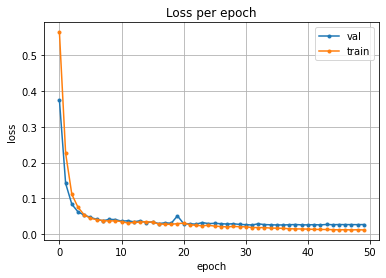

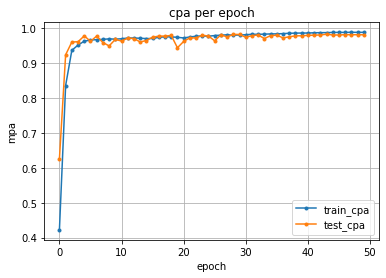

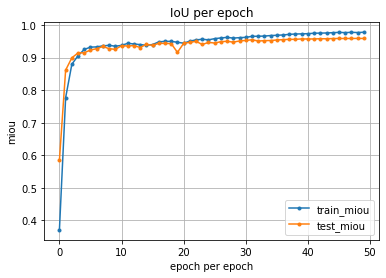

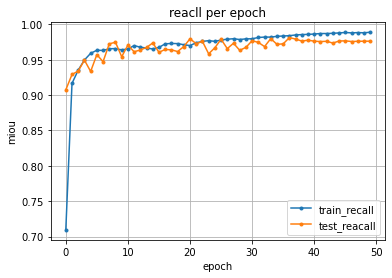

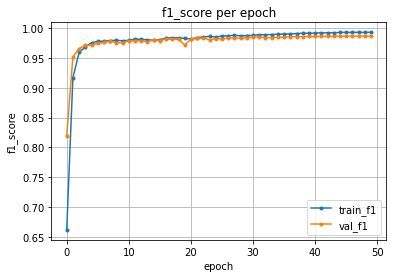

In [20]:
plot_loss(history)
pca(history)
plot_miou1(history)
recall(history)
f1(history)

# 测试数据

In [21]:
X_test = df1['id'].values
print('Test Size    : ', len(X_test))

Test Size    :  160


In [22]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
#         mask = cv2.imread(self.mask_path + self.X[idx] + '.png')

        if self.transform is not None:
            
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(288, 288, interpolation=cv2.INTER_NEAREST)
val_set = DroneTestDataset(IMAGE_PATH1, MASK_PATH1, X_test, transform=t_test)

In [23]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)

    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
#         print("image",image.size())
#         print("mask",mask.shape)

        output = model(image)
#         output = output["out"]
        metric = SegmentationMetric(2)  # ()里面表示分类
        metric.addBatch(output, mask)
#         cpa += metric.meanPixelAccuracy()
        score = metric.meanIntersectionOverUnion()
#         score = mIoU(output, mask)

        
        masked = torch.argmax(output, dim=1)
#         print("masked",masked)
        masked = masked.cpu().squeeze(0)

        print("score",score)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
#         output = output["out"]
        metric = SegmentationMetric(3)  # ()里面表示分类
        metric.addBatch(output, mask)
        cpa = metric.meanPixelAccuracy()
        f1 = metric.F1Score()
        Recall = metric.recall()
        
        masked = torch.argmax(output, dim=1)
#         print("cpa", cpa)
#         print("f1",f1)
#         print("recall",Recall)
        masked = masked.cpu().squeeze(0)
    return masked,cpa,f1,Recall


In [24]:
def miou_score(model, val_set):
    score_iou = []
    for i in tqdm(range(len(val_set))):
        img, mask = val_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [25]:
def pixel_acc(model, val_set):
    accuracy = 0
    f1score = 0
    Recall = 0
    for i in tqdm(range(len(val_set))):
        img, mask = val_set[i]
        pred_mask, cpa,f1,recall = predict_image_mask_pixel(model, img, mask)
        accuracy += cpa
        f1score += f1 
        Recall += recall
    print("精确率",accuracy/160)
    print("f1得分",f1score/160)
    print("召回率",Recall/160)
    return accuracy,f1score,recall

In [28]:
cpa,f1,recall = pixel_acc(model, val_set)
# cpa


精确率 0.9784964445451262
f1得分 0.9841757965330971
召回率 0.9725040883136732


num 0
score 0.9123638086215063


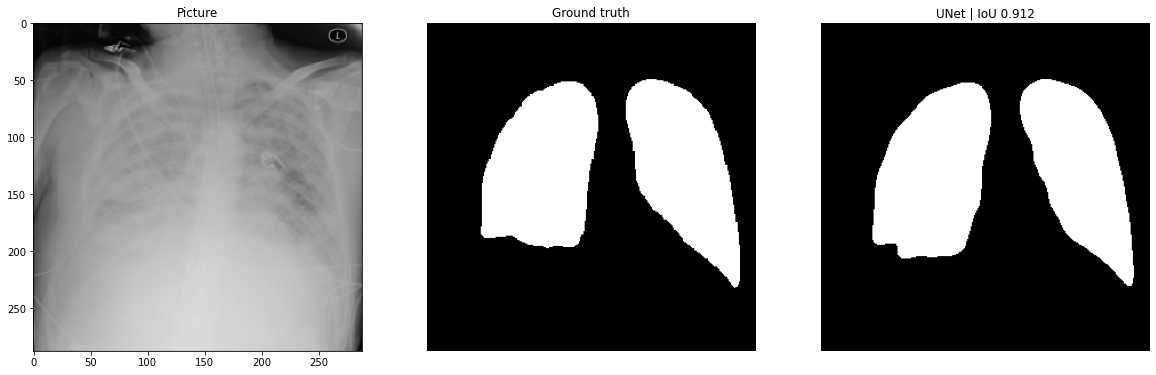

num 1
score 0.9645551654590274


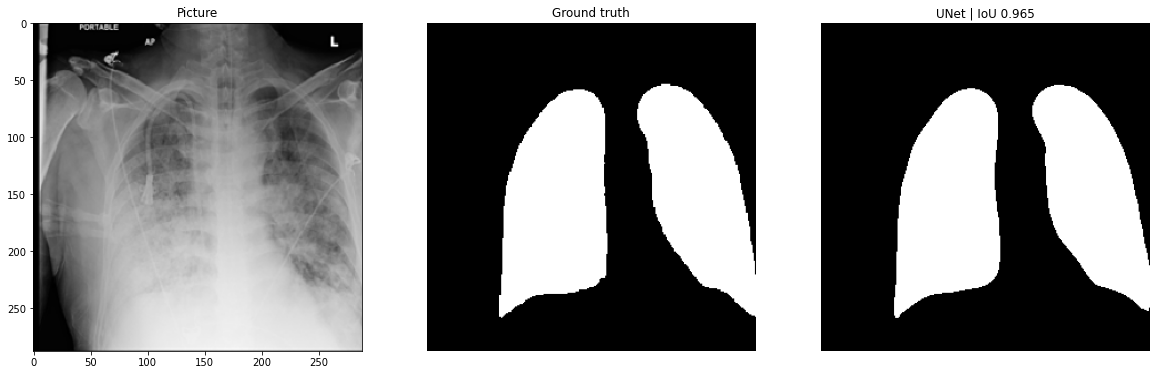

num 2
score 0.9592499630887347


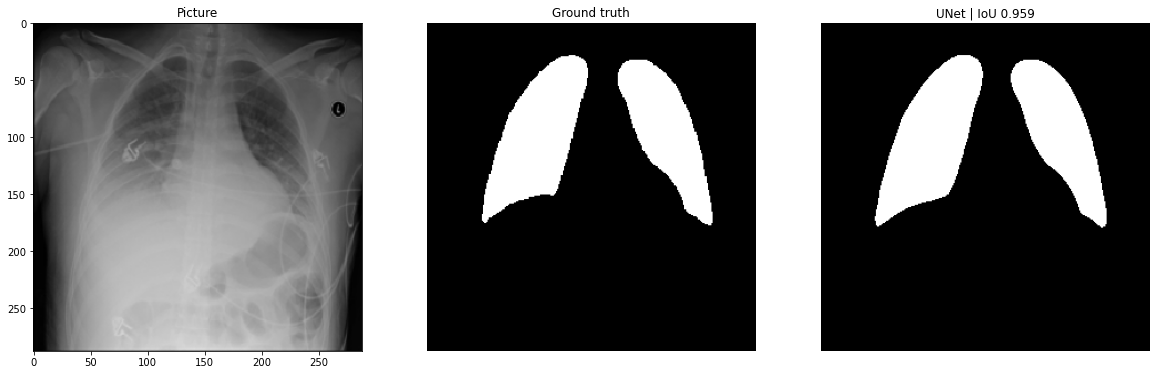

num 3
score 0.9591625743086069


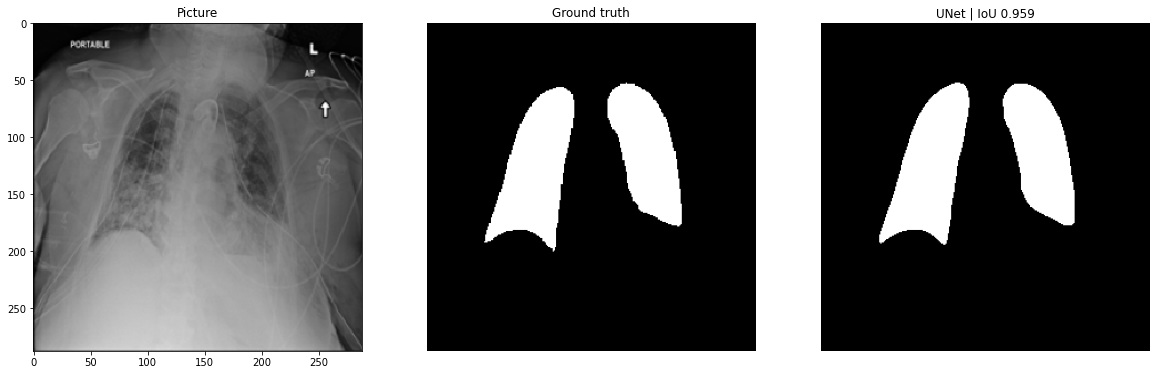

num 4
score 0.9811940432806947


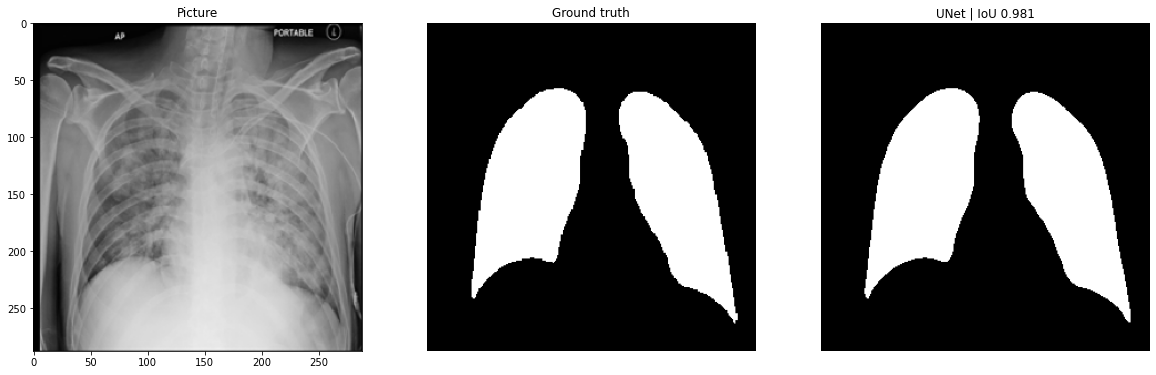

num 5
score 0.9744151046654809


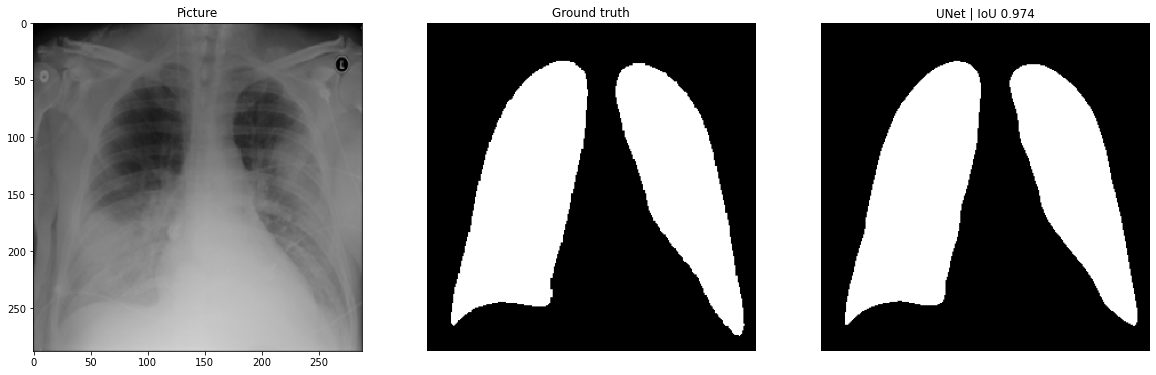

num 6
score 0.9681618569636136


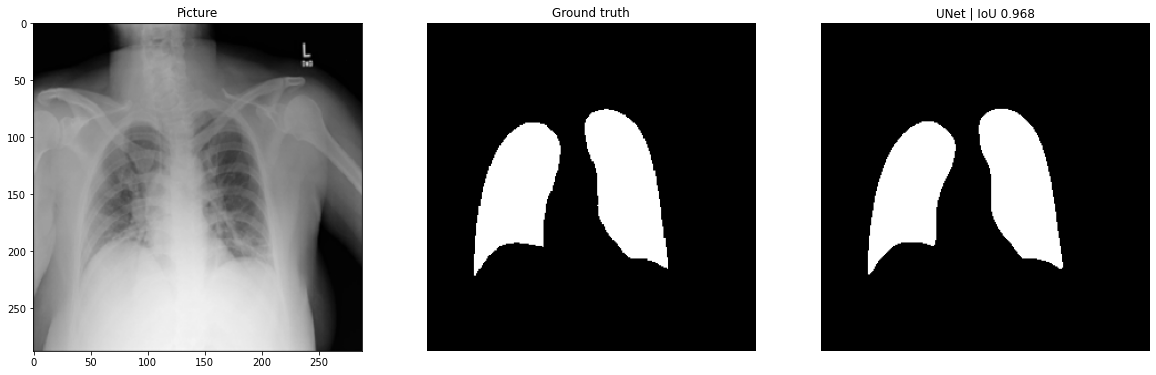

num 7
score 0.9738336959149142


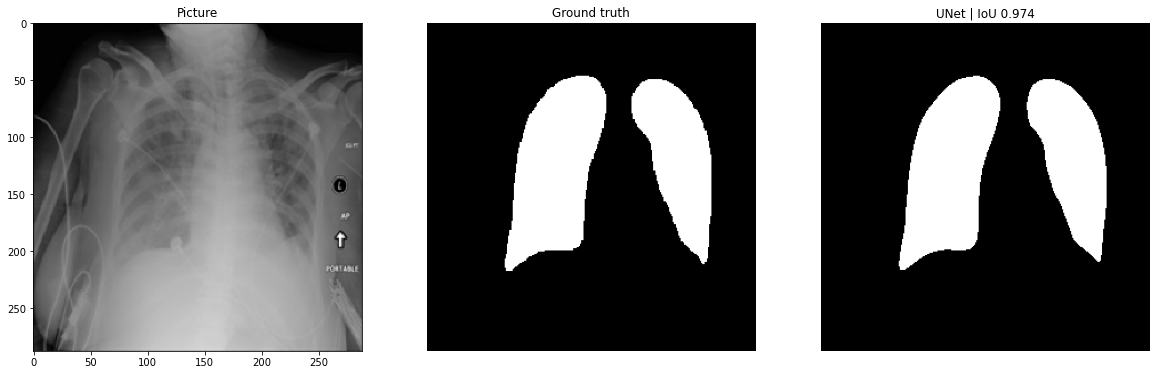

num 8
score 0.9464237516869096


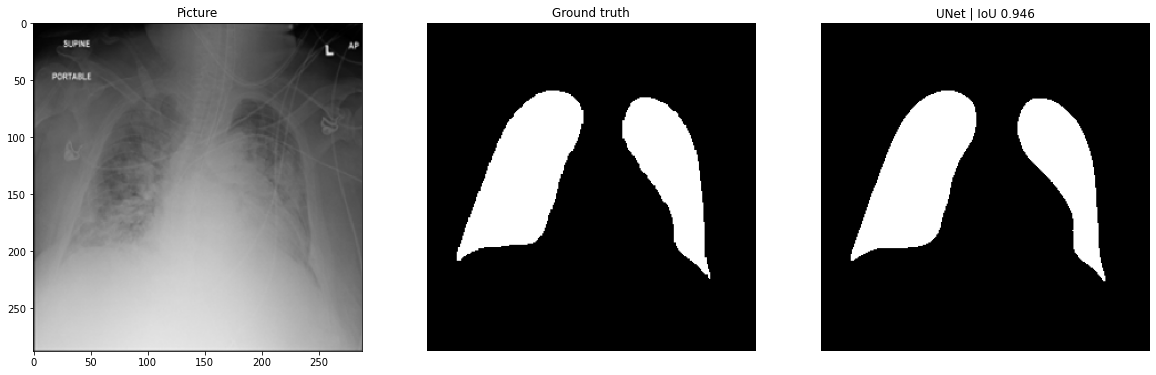

num 9
score 0.9407381855812349


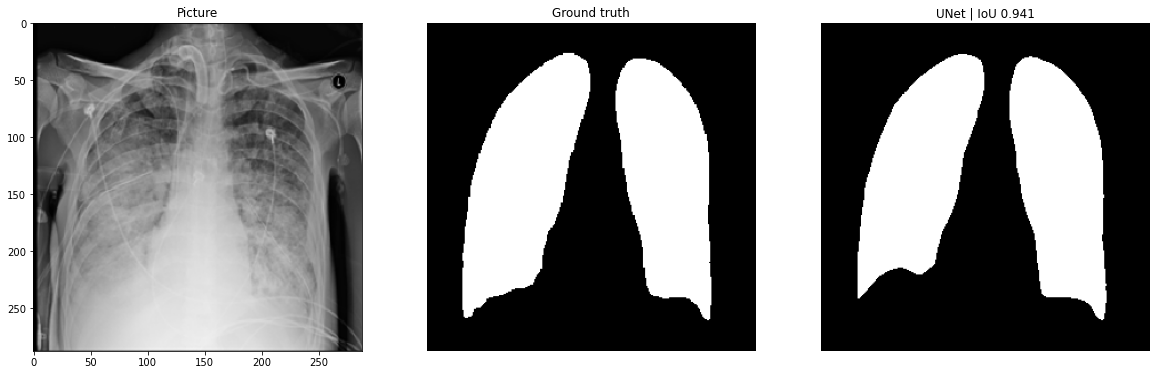

In [29]:
for i in range(10):
    print("num", i)
    image2, mask2 = val_set[i]
    pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)


    mask2 = mask2.numpy()
    pred_mask2 = pred_mask2.numpy()

    mask2 = mask2label1(mask2)
    pred_mask2 = mask2label1(pred_mask2)
    
    pred_mask2 = Image.fromarray(np.uint8(pred_mask2))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

    ax1.imshow(image2)
    ax1.set_title('Picture')


    ax2.imshow(mask2)
    ax2.set_title('Ground truth')
    ax2.set_axis_off()

    ax3.imshow(pred_mask2)
    ax3.set_title('UNet | IoU {:.3f}'.format(score2))
    ax3.set_axis_off()
    plt.savefig('C:\\Users\\MSE\\Desktop\\8.12\\'+"%03d"%(i)+'.png')
    plt.show()

